In [1]:
%autosave 0
import numpy as np
import pandas as pd

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px

from datetime import date, timedelta
from joblib import dump

import warnings
warnings.filterwarnings("ignore") 

Autosave disabled


Start Day : 28/03

Trying to predict number of new cases & deaths one day before

Working with data update everyday here : https://ourworldindata.org/coronavirus-source-data
I take the full dataset linked

In [2]:
## Today Data scrap on nb 00 
df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")

In [3]:
df.head(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
0,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,NaN,0.0,0.0,NaN,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
1,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,NaN,0.0,0.0,NaN,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
2,AFG,Asia,Afghanistan,2020-01-02,0.0,0.0,NaN,0.0,0.0,NaN,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83


In [4]:
df.tail(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
41800,NaN,NaN,International,2020-09-03,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41801,NaN,NaN,International,2020-09-04,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41802,NaN,NaN,International,2020-09-05,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df['location'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao', 'Cyprus',
       'Czech Republic', 'Democratic Republic of Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Ethiopia', 'Faeroe Islands', 'Falkland Isla

# Data Exploration

In [6]:
def massBalance(subject,df,country):
    """ Plot evolution of data by columns
    params :
        subject = name of cols concerned by the plot
        df = The Dataframe
        country = Name of location isolated for the plot
    """
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.line(x=df["date"], y=df[f"{subject}"])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [7]:
## Plotly graph will be not display on Git ##
# massBalance("total_deaths",df,"World")
# massBalance("total_deaths",df,"France")
# massBalance("total_deaths",df,"China")
# massBalance("total_deaths",df,"Italy")
# massBalance("total_deaths",df,"Spain")
# massBalance("total_deaths",df,"United States")
# massBalance("total_deaths",df,"Germany")
# massBalance("total_deaths",df,"Iran")
# massBalance("total_deaths",df,"Turkey")
# massBalance("total_deaths",df,"Brazil")

In [8]:
## Plotly graph will be not display on Git ##
# massBalance("total_cases",df,"World")
# massBalance("total_cases",df,"France")
# massBalance("total_cases",df,"China")
# massBalance("total_cases",df,"Italy")
# massBalance("total_cases",df,"Spain")
# massBalance("total_cases",df,"United States")
# massBalance("total_cases",df,"United Kingdom")
# massBalance("total_cases",df,"Germany")
# massBalance("total_cases",df,"Iran")
# massBalance("total_cases",df,"Turkey")
# massBalance("total_cases",df,"Brazil")

In [9]:
def newOverTime(subject,df,country):
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.bar(df, x=df["date"], y=df[f'{subject}'])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [10]:
## Plotly graph will be not display on Git ##
# newOverTime("new_cases",df,"World")
# newOverTime("new_cases",df,"France")
# newOverTime("new_cases",df,"China")
# newOverTime("new_cases",df,"Italy")
# newOverTime("new_cases",df,"Spain")
# newOverTime("new_cases",df,"United States")
# newOverTime("new_cases",df,"United Kingdom")
# newOverTime("new_cases",df,"Germany")
# newOverTime("new_cases",df,"Iran")
# newOverTime("new_cases",df,"Turkey")
# newOverTime("new_cases",df,"Brazil")

In [11]:
## Plotly graph will be not display on Git ##
# newOverTime("new_deaths",df,"World")
# newOverTime("new_deaths",df,"France")
# newOverTime("new_deaths",df,"China")
# newOverTime("new_deaths",df,"Italy")
# newOverTime("new_deaths",df,"Spain")
# newOverTime("new_deaths",df,"United States")
# newOverTime("new_deaths",df,"United Kingdom")
# newOverTime("new_deaths",df,"Germany")
# newOverTime("new_deaths",df,"Iran")
# newOverTime("new_deaths",df,"Turkey")
# newOverTime("new_deaths",df,"Brazil")

In [12]:
def worldrep(subject,graph_long=5,val_larg=1000000,df=df):
    fidf_mod = df.sort_values(subject, axis=0, ascending =False).head(500)
    f, ax = plt.subplots(figsize=(15, graph_long))

    ax.set(xlim=(0, val_larg), 
           ylabel= "Pays",
           xlabel= subject,
           Title= (f"{subject} by country")
          )
    ax.legend()
    sns.despine(top=True)
    ax = sns.barplot(x=fidf_mod[subject], y=fidf_mod["location"])


No handles with labels found to put in legend.


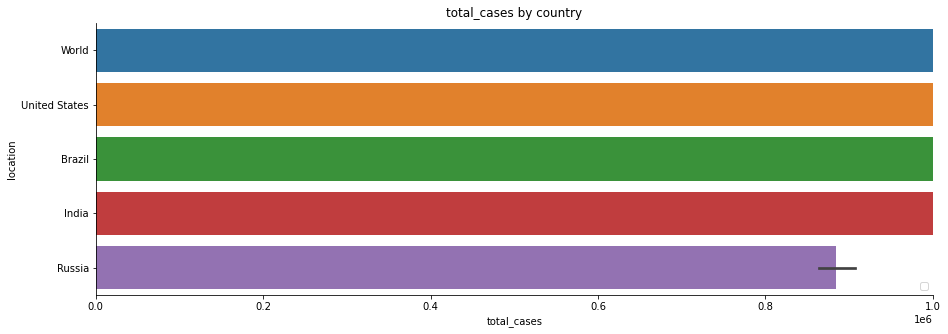

In [13]:
worldrep("total_cases")

No handles with labels found to put in legend.


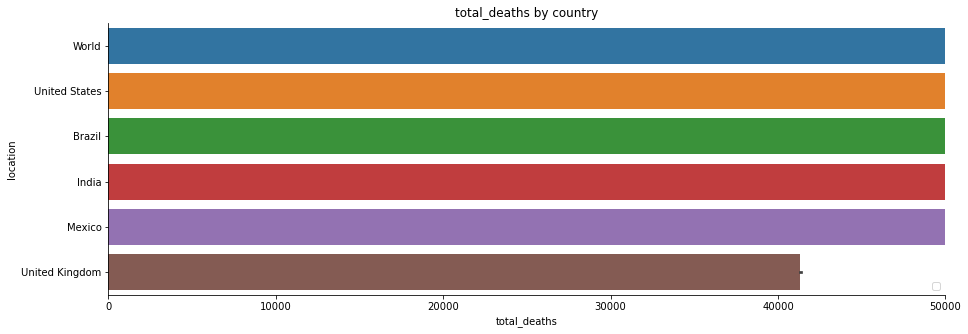

In [14]:
worldrep("total_deaths",val_larg=50000)

In [15]:
dds = df[df["date"].isin([f'{date.today()}'])]

No handles with labels found to put in legend.


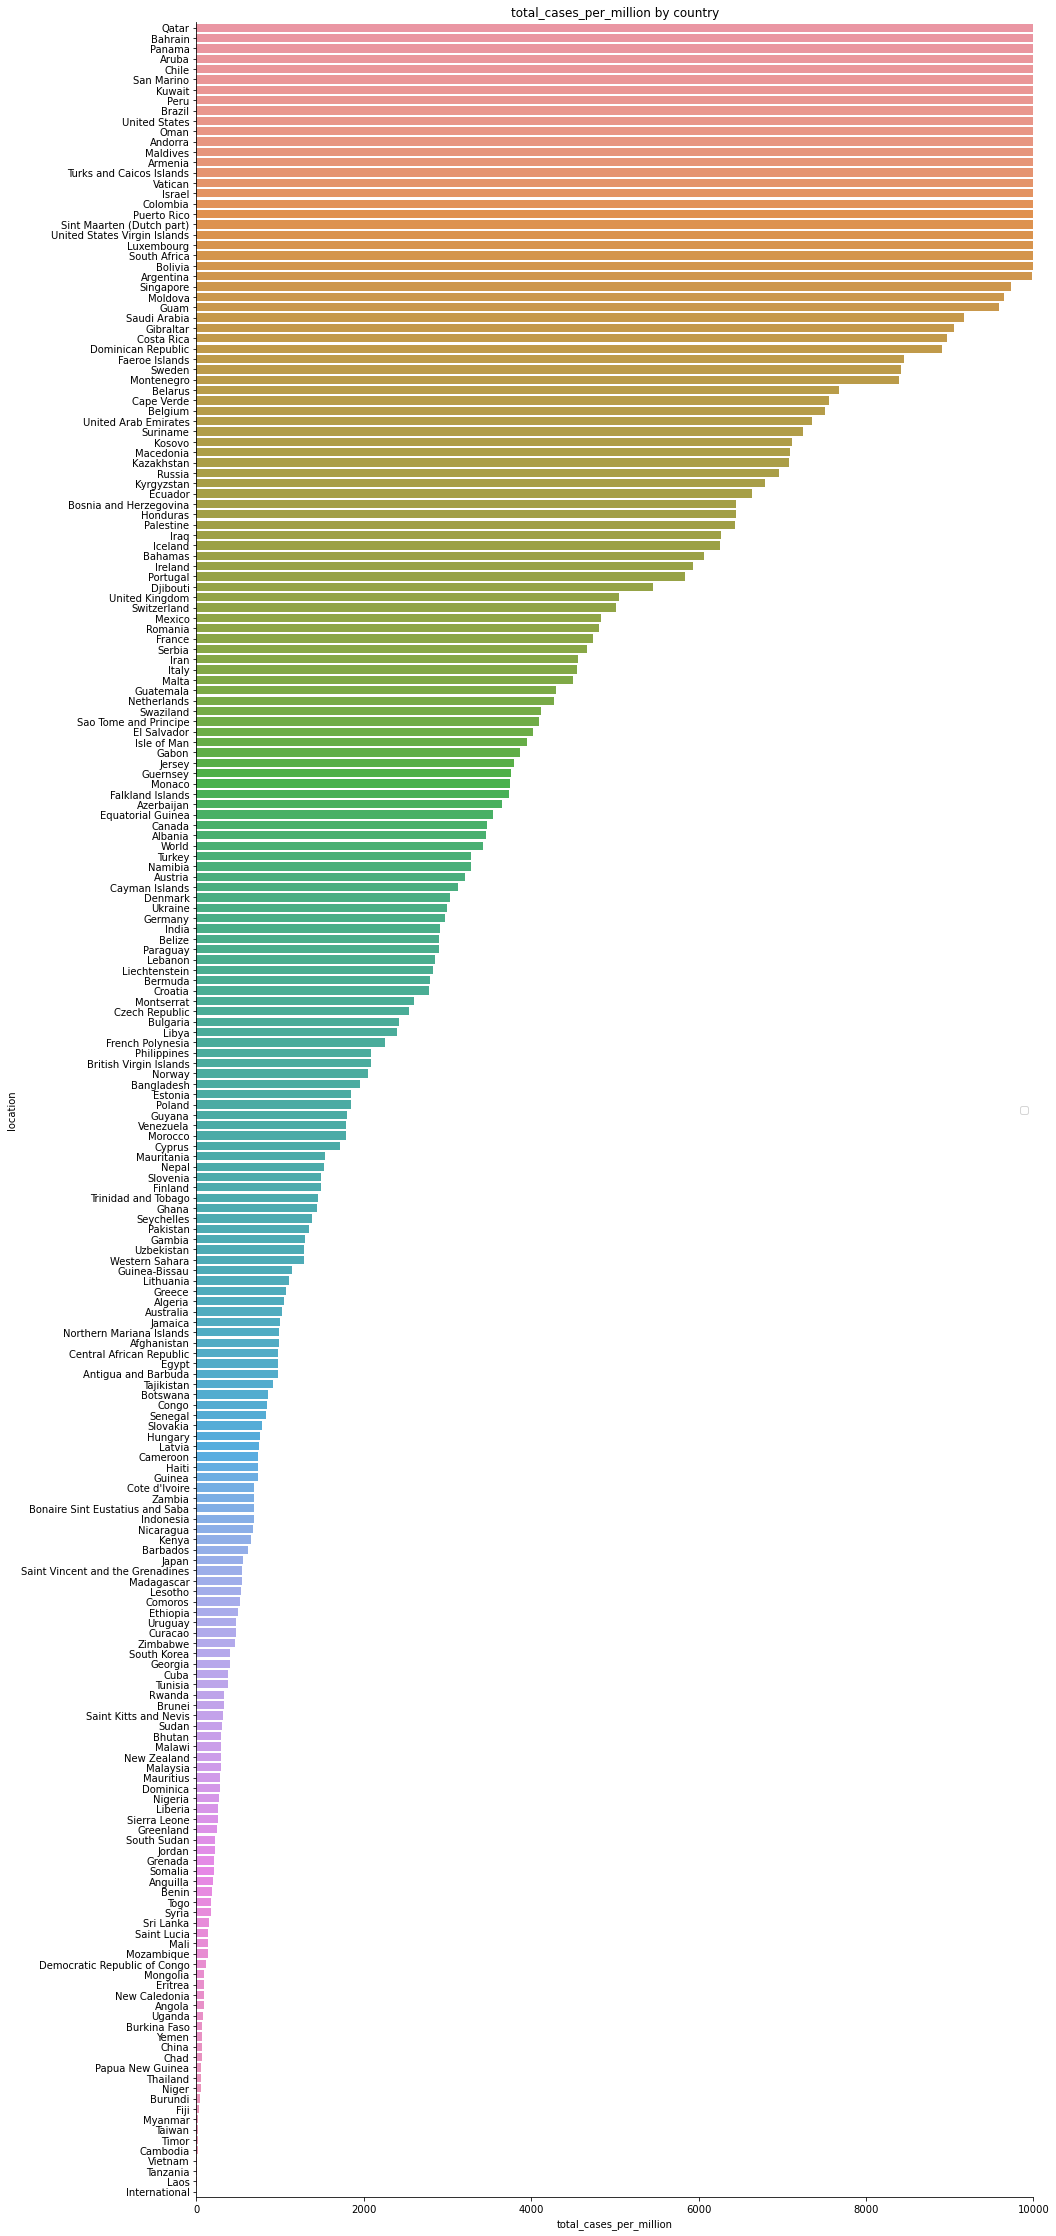

In [16]:
try:
    worldrep("total_cases_per_million",graph_long=40,val_larg=10000,df=dds)
except:
    print("Not today")

No handles with labels found to put in legend.


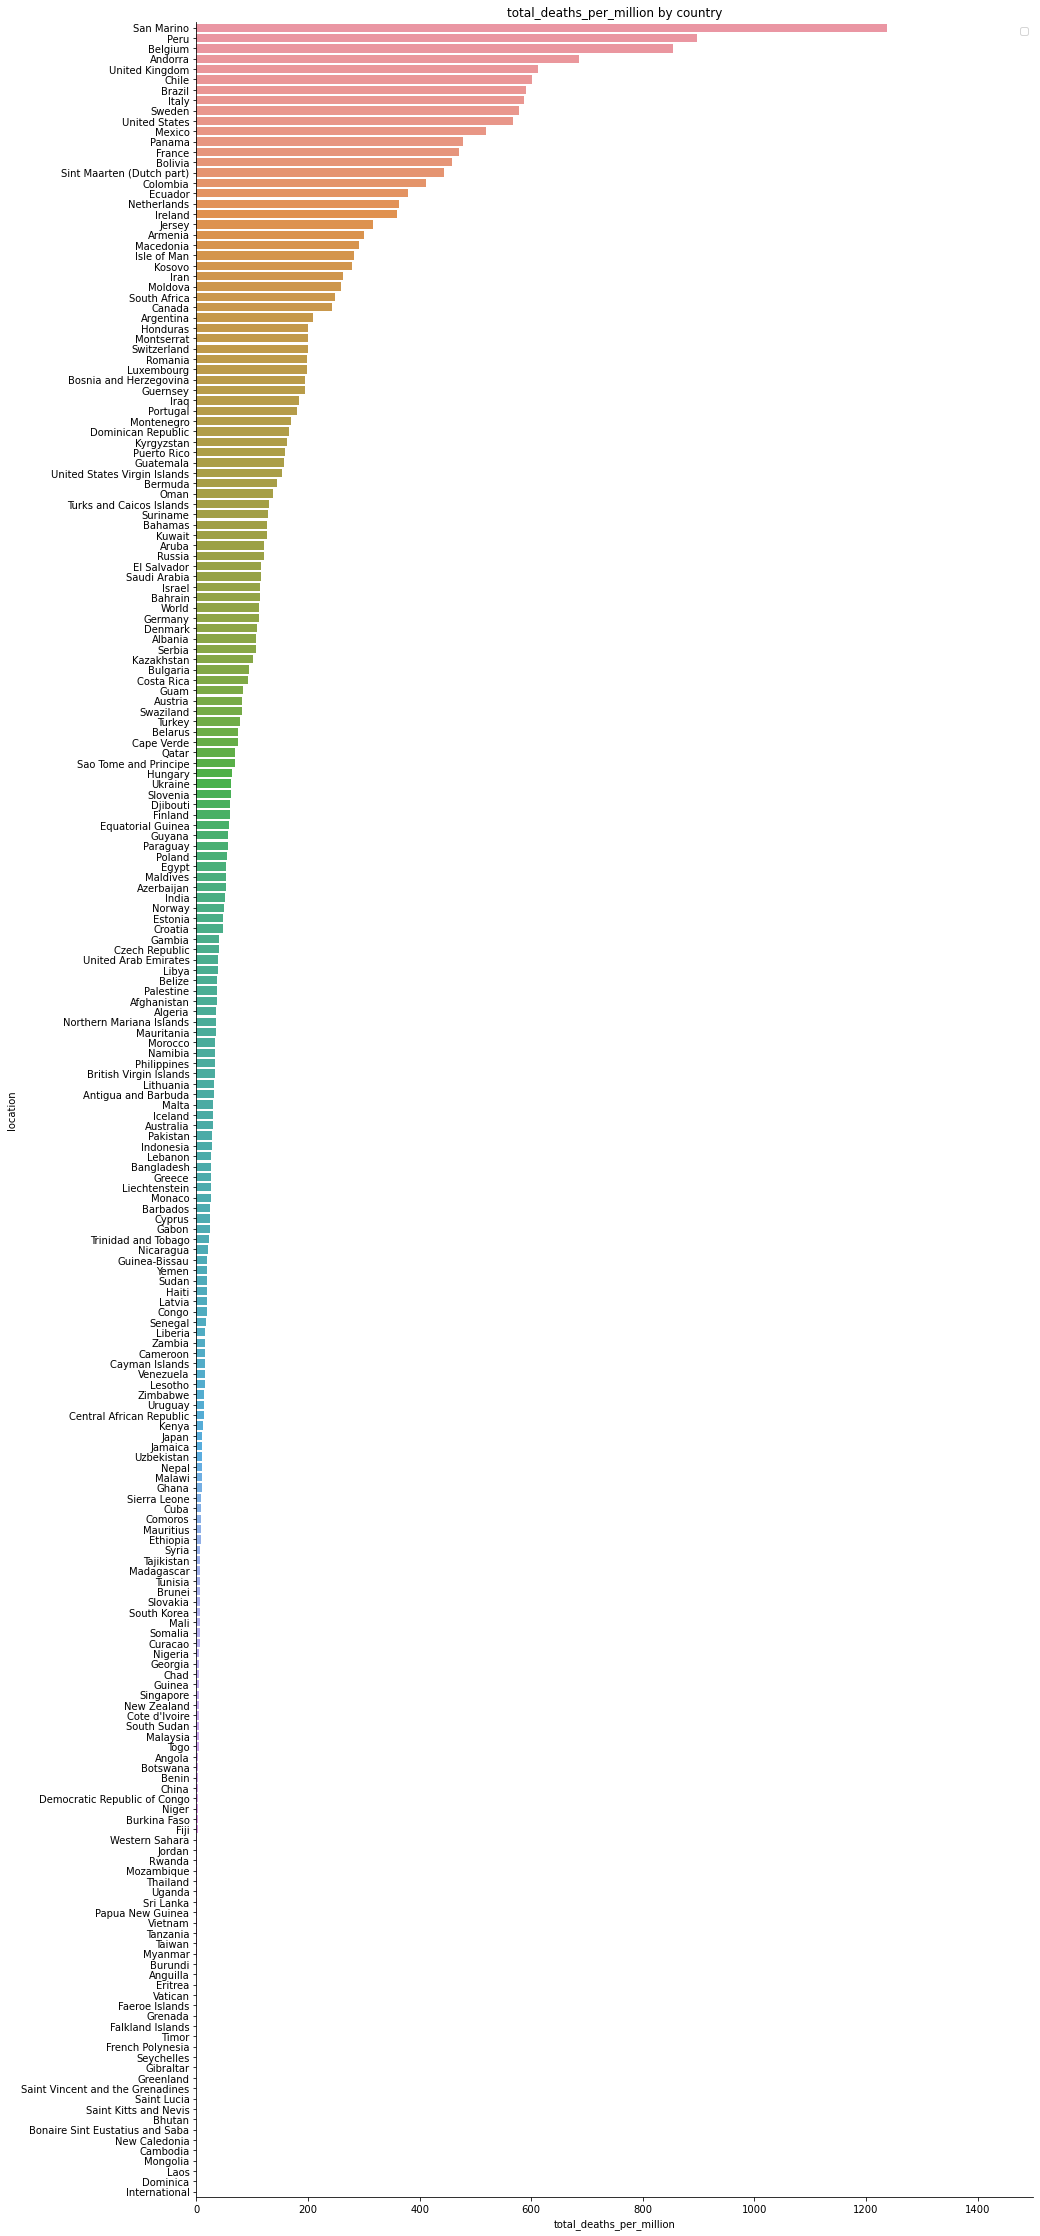

In [17]:
try :
    worldrep("total_deaths_per_million",graph_long=40,val_larg=1500,df=dds)
    is_full_data = True
except:
    is_full_data = False
    print("not today")

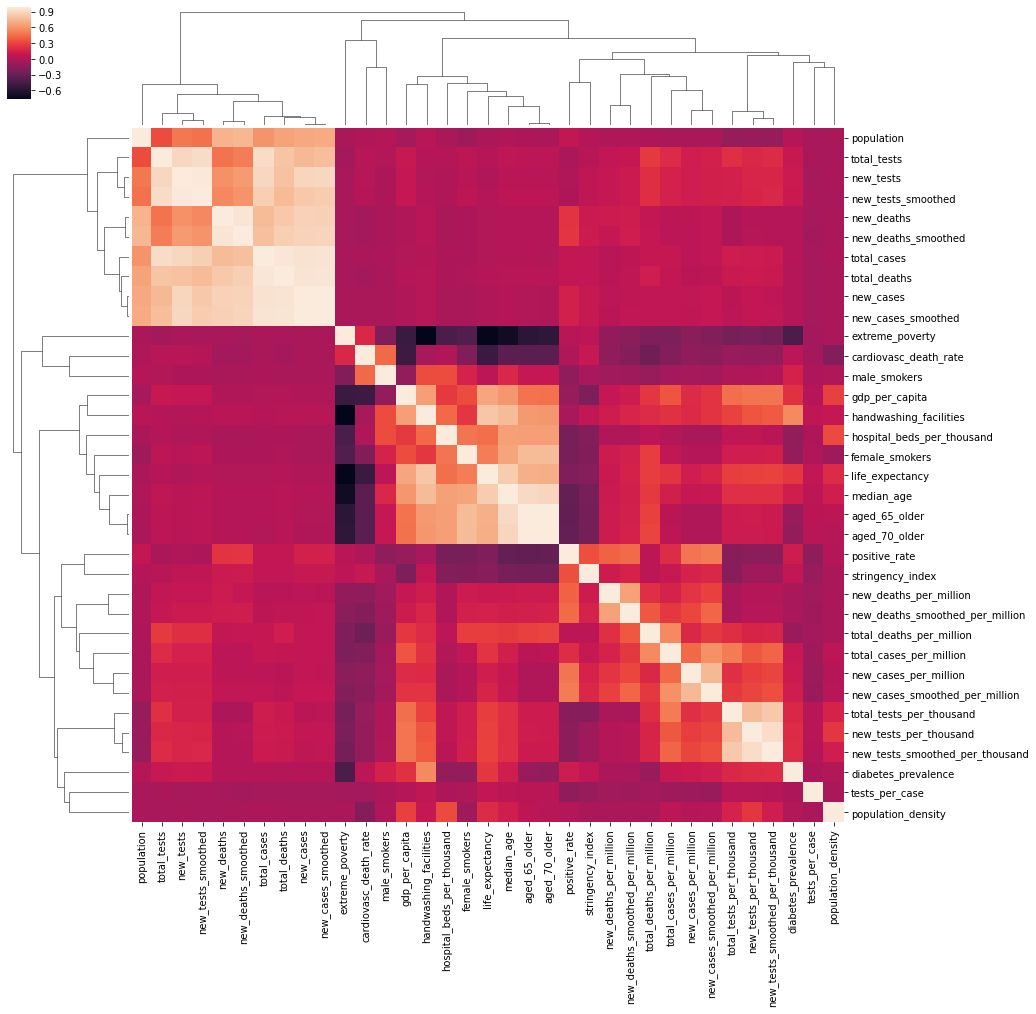

In [18]:
if is_full_data:
    corr = df.corr()
    sns.clustermap(corr,figsize=(15, 15))
else :
    print("not today")

# Modeling routines

In [19]:
def createModel(subject,periode,country,n_splits=3,max_iter=5000):
    
    df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")
    df = df[df['location'].isin([f"{country}"])] 
    vals = df[[f"{subject}"]].values
    
    imp = SimpleImputer(missing_values=np.nan, strategy='constant')
    vals = imp.fit_transform(vals)
    
    hisShape = vals.shape[0]
    x_train = []
    y_train = []

    for i in range(periode,hisShape):
        x_train.append(vals[(i-periode):i,0]) 
        y_train.append(vals[i,0])

    x_train = np.array(x_train) 
    y_train = np.array(y_train)
    
    ###############################################################
    model = ElasticNet(random_state=0,max_iter=max_iter) 
    # tol=0.01 by reducing this hp warning disapear, pred will be highter 
    ###############################################################
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = cross_val_score(model, x_train, y_train, cv=tscv)
    print(f"R^2: {scores.mean()} (+/- {scores.std()})")
    
    model.fit(x_train,y_train)
    print("Coef : ",model.coef_)
    
    return vals, x_train,y_train, model

In [20]:
def predicTomorow(vals,model,periode):
    tmw = vals[-periode:]
    lili = []
    for i in tmw:
        lili.append(int(i))
    lili = np.array(lili).reshape(1, -1) 
    res = int(model.predict(lili))
    last_day = lili[0][periode-1]
    diff_betw = res-last_day
    print(f"{periode} Last_days : ",lili)
    print("Today : ",last_day)
    print("Prediction + : ",diff_betw)
    print("Tomorow : ",res)
    return last_day, res

In [21]:
def conbine(subject,periode,country):
    vals, x_train, y_train, model = createModel(subject,periode,country)
    last_day, ress = predicTomorow(vals,model,periode)
    return last_day, ress

In [22]:
def fullRoutines(df,periode,country):
    print(f"********* For {country} **************")
    print("                                     ")
    print("--------- Total Cases -----------------")
    print("                                     ")
    last_day_cases, res1 = conbine("total_cases",periode,f"{country}")
    print("                                     ")
    print("--------- Total Death -----------------")
    print("                                     ")
    last_day_death, res2 = conbine("total_deaths",periode,f"{country}")
    print("                                     ")
    return last_day_cases, last_day_death, res1, res2

# Prediction Tomorow

In [23]:
periode = 3

In [24]:
last_day_cases, last_day_death, res1ww, res2ww = fullRoutines(df,periode,"World")
world_data = last_day_cases, last_day_death, res1ww, res2ww

********* For World **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9992120821918649 (+/- 0.0008129758942294422)
Coef :  [1.03596188e+00 9.09333239e-05 9.41622473e-05]
3 Last_days :  [[26069401 26347047 26640247]]
Today :  26640247
Prediction + :  458854
Tomorow :  27099101
                                     
--------- Total Death -----------------
                                     
R^2: 0.9996651924267893 (+/- 6.995900706853288e-05)
Coef :  [0.08571935 0.4480648  0.47641148]
3 Last_days :  [[863587 869371 874963]]
Today :  874963
Prediction + :  8183
Tomorow :  883146
                                     


In [25]:
last_day_casesfr, last_day_deathfr, res1fr, res2fr = fullRoutines(df,periode,"France")
french_data = last_day_casesfr, last_day_deathfr, res1fr, res2fr

********* For France **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.8748521545372426 (+/- 0.16964546407519543)
Coef :  [-0.73446217  0.76392451  0.97350587]
3 Last_days :  [[293024 300181 309156]]
Today :  309156
Prediction + :  6016
Tomorow :  315172
                                     
--------- Total Death -----------------
                                     
R^2: 0.8132866590904283 (+/- 0.25325753955863867)
Coef :  [-0.75134251  0.78867696  0.96166963]
3 Last_days :  [[30686 30686 30686]]
Today :  30686
Prediction + :  21
Tomorow :  30707
                                     


In [26]:
last_day_casesch, last_day_deathch, res1ch, res2ch = fullRoutines(df,periode,"China")
china_data = last_day_casesch, last_day_deathch, res1ch, res2ch

********* For China **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9351797549617903 (+/- 0.050506276419645946)
Coef :  [-0.32604645 -0.01734414  1.33765807]
3 Last_days :  [[89953 89986 90008]]
Today :  90008
Prediction + :  30
Tomorow :  90038
                                     
--------- Total Death -----------------
                                     
R^2: -133.11655184809146 (+/- 189.54452142654569)
Coef :  [-0.07713399  0.01244828  1.05654985]
3 Last_days :  [[4727 4728 4728]]
Today :  4728
Prediction + :  6
Tomorow :  4734
                                     


In [27]:
last_day_casesit, last_day_deathit, res1it, res2it = fullRoutines(df,periode,"Italy")
italy_data = last_day_casesit, last_day_deathit, res1it, res2it

********* For Italy **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9568841704958451 (+/- 0.05995416500991374)
Coef :  [-0.82466493  0.89854556  0.92545013]
3 Last_days :  [[271515 272912 274644]]
Today :  274644
Prediction + :  1226
Tomorow :  275870
                                     
--------- Total Death -----------------
                                     
R^2: 0.671729971175583 (+/- 0.43805795173078144)
Coef :  [-0.82702604  0.89884383  0.92727309]
3 Last_days :  [[35497 35507 35518]]
Today :  35518
Prediction + :  29
Tomorow :  35547
                                     


In [28]:
try:
    last_day_casessp, last_day_deathsp, res1sp, res2sp = fullRoutines(df,periode,"Spain")
    spain_data = last_day_casessp, last_day_deathsp, res1sp, res2sp
except:
    print("No spain update")

********* For Spain **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9726690577823184 (+/- 0.029359231706703272)
Coef :  [-0.48523472  0.30922549  1.17900362]
3 Last_days :  [[479554 488513 498989]]
Today :  498989
Prediction + :  7914
Tomorow :  506903
                                     
--------- Total Death -----------------
                                     
R^2: 0.04697302341023376 (+/- 1.0913409426369378)
Coef :  [-0.72636128  0.62952132  1.09587803]
3 Last_days :  [[29194 29234 29418]]
Today :  29418
Prediction + :  56
Tomorow :  29474
                                     


In [29]:
last_day_casesus, last_day_deathus, res1us, res2us = fullRoutines(df,periode,"United States")
usa_data = last_day_casesus, last_day_deathus, res1us, res2us

********* For United States **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.978718074625878 (+/- 0.029736891153879518)
Coef :  [0.07959764 0.46327651 0.47216816]
3 Last_days :  [[6114406 6150655 6201726]]
Today :  6201726
Prediction + :  77289
Tomorow :  6279015
                                     
--------- Total Death -----------------
                                     
R^2: 0.9963635770240872 (+/- 0.003854652490362939)
Coef :  [-0.50690629  0.71722242  0.79240271]
3 Last_days :  [[185744 186797 187765]]
Today :  187765
Prediction + :  1188
Tomorow :  188953
                                     


In [30]:
last_day_casesuk, last_day_deathuk, res1uk, res2uk = fullRoutines(df,periode,"United Kingdom")
uk_data = last_day_casesuk, last_day_deathuk, res1uk, res2uk

********* For United Kingdom **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9243595235307401 (+/- 0.10636336022363804)
Coef :  [-0.71884877  0.84743587  0.87164289]
3 Last_days :  [[338676 340411 342351]]
Today :  342351
Prediction + :  1618
Tomorow :  343969
                                     
--------- Total Death -----------------
                                     
R^2: 0.3335852506594612 (+/- 0.9036850561025291)
Coef :  [-0.77050762  0.83158061  0.93829285]
3 Last_days :  [[41514 41527 41537]]
Today :  41537
Prediction + :  45
Tomorow :  41582
                                     


In [31]:
last_day_casesger, last_day_deathger, res1ger, res2ger = fullRoutines(df,periode,"Germany")
ger_data = last_day_casesger, last_day_deathger, res1ger, res2ger

********* For Germany **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.8847993350388085 (+/- 0.1608736415024662)
Coef :  [-0.79389223  0.85649601  0.93713281]
3 Last_days :  [[246116 246948 248997]]
Today :  248997
Prediction + :  777
Tomorow :  249774
                                     
--------- Total Death -----------------
                                     
R^2: 0.3413706862842128 (+/- 0.9209648925570135)
Coef :  [-0.78998041  0.8407058   0.94856577]
3 Last_days :  [[9319 9319 9324]]
Today :  9324
Prediction + :  6
Tomorow :  9330
                                     


In [32]:
last_day_casesIran, last_day_deathIran, res1Iran, res2Iran = fullRoutines(df,periode,"Iran")
Iran_data = last_day_casesIran, last_day_deathIran, res1Iran, res2Iran

********* For Iran **************
                                     
--------- Total Cases -----------------
                                     
R^2: -5.75553916919382 (+/- 9.552232801144399)
Coef :  [0.23416652 0.38907962 0.38786542]
3 Last_days :  [[378752 380746 382772]]
Today :  382772
Prediction + :  3940
Tomorow :  386712
                                     
--------- Total Death -----------------
                                     
R^2: 0.9629070447337873 (+/- 0.05185622832331072)
Coef :  [0.0217123  0.49922575 0.49051611]
3 Last_days :  [[21797 21926 22044]]
Today :  22044
Prediction + :  244
Tomorow :  22288
                                     


In [33]:
last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk = fullRoutines(df,periode,"Turkey")
Turk_data = last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk

********* For Turkey **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9985204146636741 (+/- 0.0017851428330751635)
Coef :  [-0.71900612  0.84025638  0.87613047]
3 Last_days :  [[273301 274943 276555]]
Today :  276555
Prediction + :  1330
Tomorow :  277885
                                     
--------- Total Death -----------------
                                     
R^2: 0.9990451665115548 (+/- 0.0007748399665967355)
Coef :  [-0.81049058  0.89258754  0.91527466]
3 Last_days :  [[6462 6511 6564]]
Today :  6564
Prediction + :  39
Tomorow :  6603
                                     


In [34]:
last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz = fullRoutines(df,periode,"Brazil")
Braz_data = last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz

********* For Brazil **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.6031714187041777 (+/- 0.5571737207654485)
Coef :  [-0.10201879  0.49065042  0.62791239]
3 Last_days :  [[3997865 4041638 4092832]]
Today :  4092832
Prediction + :  59179
Tomorow :  4152011
                                     
--------- Total Death -----------------
                                     
R^2: 0.4769151054942626 (+/- 0.7352930587426588)
Coef :  [-0.08648786  0.50715858  0.59163068]
3 Last_days :  [[123780 124614 125521]]
Today :  125521
Prediction + :  1512
Tomorow :  127033
                                     


In [35]:
model_data = [world_data, french_data, italy_data, spain_data, usa_data,
              china_data, uk_data, ger_data, Iran_data, Turk_data, Braz_data]

In [36]:
model_data

[(26640247, 874963, 27099101, 883146),
 (309156, 30686, 315172, 30707),
 (274644, 35518, 275870, 35547),
 (498989, 29418, 506903, 29474),
 (6201726, 187765, 6279015, 188953),
 (90008, 4728, 90038, 4734),
 (342351, 41537, 343969, 41582),
 (248997, 9324, 249774, 9330),
 (382772, 22044, 386712, 22288),
 (276555, 6564, 277885, 6603),
 (4092832, 125521, 4152011, 127033)]

In [37]:
# dump(model_data, "endPoint/CovidDataPred.joblib")

In [38]:
def popPred(country,rez1,rez2):
    pop_pred = pd.DataFrame()

    pop_pred.loc[0,"date"] = date.today()
    pop_pred.loc[0,"country"] = country
    pop_pred.loc[0,"total_cases_predict"] = rez1
    pop_pred.loc[0,"total_cases_real"] = 0
    pop_pred.loc[0,"total_deaths_predict"] = rez2
    pop_pred.loc[0,"total_deaths_real"] = 0
    pop_pred.loc[0,"error_abs_cases"] = 0
    pop_pred.loc[0,"error_abs_deaths"] = 0
    
    return pop_pred

In [39]:
df_pop_pred1 = popPred("France",res1fr, res2fr)
df_pop_pred2 = popPred("China",res1ch, res2ch)
df_pop_pred3 = popPred("Italy",res1it, res2it)
df_pop_pred4 = popPred("Spain",res1sp, res2sp)
df_pop_pred5 = popPred("United States",res1us, res2us)
df_pop_pred6 = popPred("World",res1ww, res2ww)
df_pop_pred7 = popPred("United Kingdom",res1uk, res2uk)
df_pop_pred8 = popPred("Germany",res1ger, res2ger)
df_pop_pred9 = popPred("Iran",res1Iran, res2Iran)
df_pop_pred10 = popPred("Turkey",res1Turk, res2Turk)
df_pop_pred11 = popPred("Brazil",res1Braz, res2Braz)

frames = [df_pop_pred1, df_pop_pred2, df_pop_pred3, df_pop_pred4,
          df_pop_pred5, df_pop_pred6, df_pop_pred7, df_pop_pred8,
          df_pop_pred9, df_pop_pred10, df_pop_pred11]

predpred = pd.concat(frames)
predpred

,date,country,total_cases_predict,total_cases_real,total_deaths_predict,total_deaths_real,error_abs_cases,error_abs_deaths
0,2020-09-05,France,315172.0,0.0,30707.0,0.0,0.0,0.0
0,2020-09-05,China,90038.0,0.0,4734.0,0.0,0.0,0.0
0,2020-09-05,Italy,275870.0,0.0,35547.0,0.0,0.0,0.0
0,2020-09-05,Spain,506903.0,0.0,29474.0,0.0,0.0,0.0
0,2020-09-05,United States,6279015.0,0.0,188953.0,0.0,0.0,0.0
0,2020-09-05,World,27099101.0,0.0,883146.0,0.0,0.0,0.0
0,2020-09-05,United Kingdom,343969.0,0.0,41582.0,0.0,0.0,0.0
0,2020-09-05,Germany,249774.0,0.0,9330.0,0.0,0.0,0.0
0,2020-09-05,Iran,386712.0,0.0,22288.0,0.0,0.0,0.0
0,2020-09-05,Turkey,277885.0,0.0,6603.0,0.0,0.0,0.0


In [40]:
predpred.to_csv(f"AzureSC\\Pred\\predDf{date.today()}.csv")